In [235]:
#!pip install fastai==0.7.0 

In [255]:
#import packages
import math

from time import time
import datetime

import pandas as pd
import numpy as np
import quandl

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#importing required libraries
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from fastai.structured import draw_tree

from IPython.display import Image

#### Create dataframe from csv

In [237]:
df = pd.read_csv('tesla.csv')
df.index = df['Date']
# sort df by date
df = df.sort_index(ascending=True, axis=0)

In [238]:
df.head()

Date      Date.1   Open   High    Low  Close     Volume  \
Date                                                                        
2012-01-03  2012-01-03  2012-01-03  28.94  29.50  27.65  28.08   928100.0   
2012-01-04  2012-01-04  2012-01-04  28.21  28.67  27.50  27.71   630100.0   
2012-01-05  2012-01-05  2012-01-05  27.76  27.93  26.85  27.12  1005500.0   
2012-01-06  2012-01-06  2012-01-06  27.20  27.79  26.41  26.91   986300.0   
2012-01-09  2012-01-09  2012-01-09  27.00  27.49  26.12  27.25   897000.0   

            Ex-Dividend  Split Ratio  Adj. Open  ...  Adj. Volume          ds  \
Date                                             ...                            
2012-01-03          0.0          1.0      28.94  ...     928100.0  2012-01-03   
2012-01-04          0.0          1.0      28.21  ...     630100.0  2012-01-04   
2012-01-05          0.0          1.0      27.76  ...    1005500.0  2012-01-05   
2012-01-06          0.0          1.0      27.20  ...     986300.0  2012-01-06   
2012-01-09          0.0          1.0      27.00  ...     897000.0  2012-01-09   

                y  Daily Change  Year  Month  Week  Day  Dayofweek  Dayofyear  
Date                                                                           
2012-01-03  28.08         -0.86  2012      1     1    3          1          3  
2012-01-04  27.71         -0.50  2012      1     1    4          2          4  
2012-01-05  27.12         -0.64  2012      1     1    5          3          5  
2012-01-06  26.91         -0.29  2012      1     1    6          4          6  
2012-01-09  27.25          0.25  2012      1     2    9          0          9  

[5 rows x 23 columns]

#### Helper function to calculate root mean square and R-Squared values

In [239]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_val), y_val),
                m.score(X_train, y_train), m.score(X_val, y_val)]
    print(f"rmse train {res[0]}, rmse val {res[1]}, r^2 train {res[2]}, r^2 val {res[3]}")

In this post, we will aim at having a deeper understanding of Random Forest by taking OHLC (open-high-low-close) data for Tesla stock for 5 year period. We will keep unrelated discussion at minimum and try to focus on everything that is related to our understanding of Random Forest for this post.

We will experiment with few features in our dataset to predict the adjusted closing price of Tesla stock for a particular day. These predictions aren't necessarily good but are only used for illustrative purposes, since the intention of this post is to learn about Random Forest.

An accompanying Jupyter notebook and dataset is provided here: 

Code is based on scikit-learn and fastai 0.7.0 packages.

#### Decision Trees

We will start by keeping things as simple as possible and later build on our understanding from this tutorial. For now, we will just say that Random Forests are composed of multiple Decision Trees. We will ignore the "Random" and "Forest" part of this equation for now. 

As the name suggests, decisions are made by splitting data into groups that are homogenous within themselves but heterogenous with others. A split is based on some criteria (score) that achieves the best possible division of data in a way that optimizes for that criteria. For example, criteria can be a decision split that reduces the "mean squared error". We call this criteria, information gain which basically tells us how much our criteria improves as we keep on making those splits. Two splits at each node generally suffice because the tree can have an infinite depth (as long as some stopping condition is reached) so there is no need to make more than two splits at each node.

A single Decision Tree looks something like the following (ignore the numbers in the nodes for now):

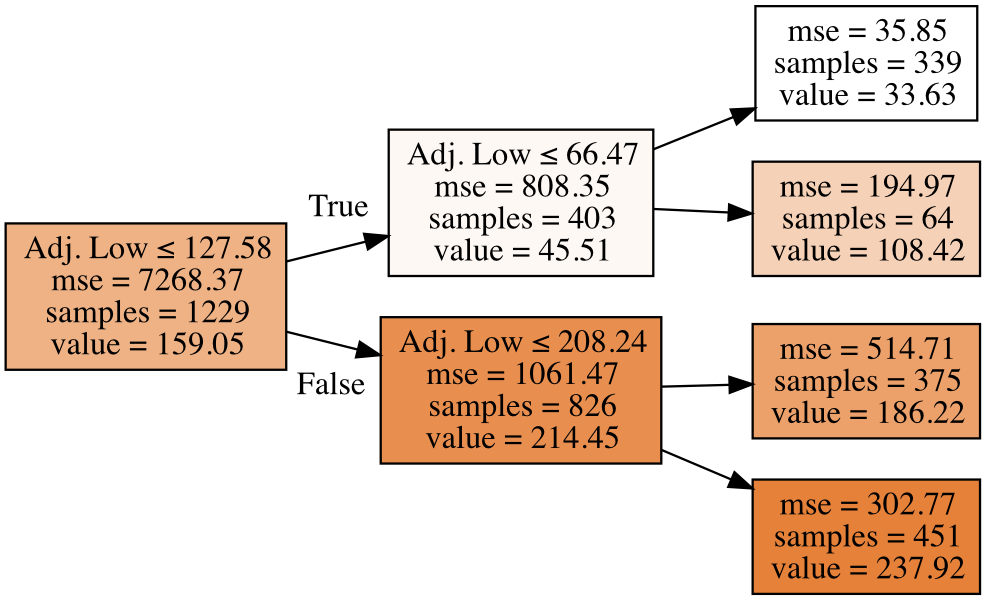

In [256]:
Image(filename = 'image1.png')

We will start by first constructing and visualizing a very simple single Decision Tree using scikit learn and some code from the fastai course.

To keep things simple, we will only use a single feature for now, the Adj. Open price.

#### Available columns

In [240]:
df.columns

Index(['Date', 'Date.1', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Ex-Dividend', 'Split Ratio', 'Adj. Open', 'Adj. High', 'Adj. Low',
       'Adj. Close', 'Adj. Volume', 'ds', 'y', 'Daily Change', 'Year', 'Month',
       'Week', 'Day', 'Dayofweek', 'Dayofyear'],
      dtype='object')

In [241]:
TOTAL = df.count()[0]
N_VALID = 90 # Three months
TRAIN = TOTAL - N_VALID
df_small = df
features = ['Adj. Open']
# features = ['Adj. Open', 'Adj. Low', 'Adj. Close']
X_df = df_small[features]
y_df = df_small['y']

X_train, X_val = X_df[:TRAIN], X_df[TRAIN:]
y_train, y_val = y_df[:TRAIN], y_df[TRAIN:]

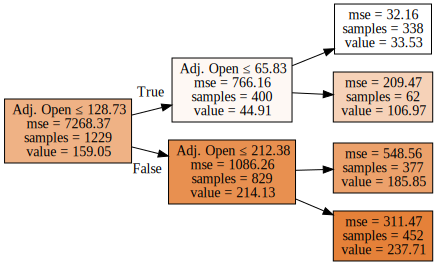

In [242]:
model = RandomForestRegressor(n_estimators=1, max_depth=2, bootstrap=False, min_samples_leaf=1)
model.fit(X_train, y_train)
draw_tree(model.estimators_[0], X_train, precision=2)

Each node in this case predicts the `value` to be the mean of y. You can test this out by yourself for the first node as follows.

In [243]:
y_train.mean()

159.05220496338478

`samples` is the number of rows used and `mse` is the mean squared error.

At depth = 0, the best prediction that it can make for Adj. Open with the available information at that node is that the predicted y is the average, which is only fair as it hasn't done much at that point.

At depth = 1, the model has found a split at Adj. Open = 128.73 such that any value less than or equal to 128.73 goes into the lower (False) node and everything else goes to the upper (True) node.

For each individual split, 
- it iterates through all the rows (since bootstrap is disabled)
- at each iteration, it partitions `X_train` into left and right hand side (lhs, rhs) and calculates some score and stores it
- after it has gone through all iterations, it selects the partition that optimizes the criteria (gives a lower mse in this case), i.e. decides on the split

We deliberately skipped explaining parameters in `RandomForestRegressor` so lets discuss this here before we dive deeper.

```
RandomForestRegressor(n_estimators=1, max_depth=2, bootstrap=False, min_samples_leaf=1)
```

`n_estimators`: Specifies the number of decision trees we want to use. Since we are ignoring the "Random" and "Forest" part of the equation, we want to limit it to a single Decision Tree. Remember that Random Forest is just an ensemble of Decision Trees.

`max_depth`: The depth till which we want to go per decision tree. To keeps things simple and easily visualizable, we have kept it to two for now.

`bootstrap`: Bootstrap is a technique to pick random samples with replacement. We 
have disabled it for better explainability.

`min_samplpes_leaf`: This is the minimum number of samples required before considering a tree as leaf and stop splitting. In case where `max_depth` is set, it obviously takes precedence over `min_samples_leaf`.



Now, what happens when there are more than one feature?

In that case, it repeats the aforementioned procedure for all the features and selects the one that gives the lowest mse. This is demonstrated below for the same dataset.

#### RMSE and R-Squared for model with single feature

In [244]:
print_score(model)

rmse train 17.384888739353396, rmse val 19.506417396221188, r^2 train 0.9584178577580958, r^2 val 0.5602690120041153


#### RMSE and R-Squared for model with two features

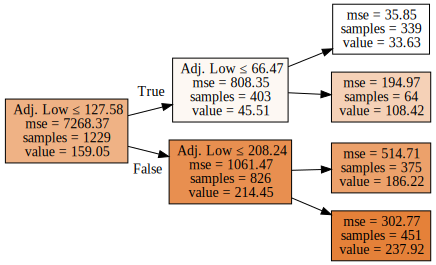

rmse train 16.976452987498227, rmse val 19.357544984072113, r^2 train 0.9603487449090349, r^2 val 0.5669554273097887


In [245]:
df_small = df
features = ['Adj. Open', 'Adj. Low']

X_df = df_small[features]
y_df = df_small['y']

X_train, X_val = X_df[:TRAIN], X_df[TRAIN:]
y_train, y_val = y_df[:TRAIN], y_df[TRAIN:]

model = RandomForestRegressor(n_estimators=1, max_depth=2, bootstrap=False, min_samples_leaf=1)
model.fit(X_train, y_train)
draw_tree(model.estimators_[0], X_train, precision=2)

print_score(model)

Notice how the model decided to split on Adj. Low instead of Adj. Open as opposed to when we forced it to only use Adj. Open for predictions in the previous case. We can also see why it did that. In the second model RMSE, obtained is lower and R-squared is higher for both train and validation datasets. Pretty cool stuff!

Now lets toss in another feature and see how it performs.

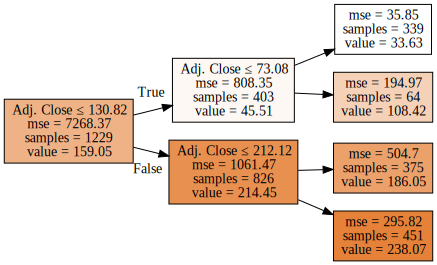

rmse train 16.81048890819006, rmse val 19.268735911850047, r^2 train 0.9611202272940632, r^2 val 0.5709197798942935


In [246]:
df_small = df
features = ['Adj. Open', 'Adj. Low', 'Adj. Close']

X_df = df_small[features]
y_df = df_small['y']

X_train, X_val = X_df[:TRAIN], X_df[TRAIN:]
y_train, y_val = y_df[:TRAIN], y_df[TRAIN:]

model = RandomForestRegressor(n_estimators=1, max_depth=2, bootstrap=False, min_samples_leaf=1)
model.fit(X_train, y_train)
draw_tree(model.estimators_[0], X_train, precision=2)

print_score(model)

Third model seems to be the best but there is a catch! Adj. Close is the same as y, the value we are trying to predict and the model naturally comes to the conclusion that Adj. Close is the best feature to predict y. Wow!

But this is just mentioned to prove a point. We would never use y to predict y!

So now that we have a basic understanding of Decision Trees, lets try to properly fit a Decision Tree model with just two features, Adj. Open and Adj. Low.

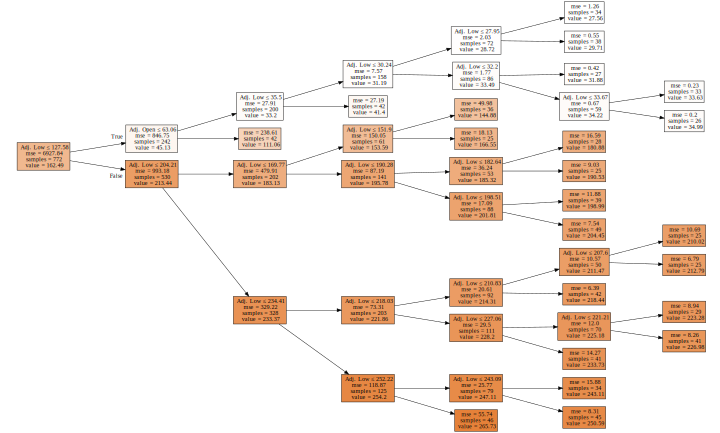

rmse train 5.272029026362083, rmse val 5.330317829943744, r^2 train 0.9961759935699128, r^2 val 0.9671649065646027


In [247]:
df_small = df
features = ['Adj. Open', 'Adj. Low']

X_df = df_small[features]
y_df = df_small['y']

X_train, X_val = X_df[:TRAIN], X_df[TRAIN:]
y_train, y_val = y_df[:TRAIN], y_df[TRAIN:]

model = RandomForestRegressor(n_estimators=1, bootstrap=True, min_samples_leaf=25)
model.fit(X_train, y_train)
draw_tree(model.estimators_[0], X_train, precision=2)

print_score(model)

In [248]:
model.estimators_[0].get_depth()

6

We have managed to vastly improve R-Squared for both train and validation set. Since there was no limit on the depth, the final tree that was build turned out having a depth of 6 with at least a minimum of 25 samples in it's leaf nodes. To go further deep, it has to at least have 25 samples in the leaf, or else it stops. We have also enabled bootstrapping to avoid overfitting.

We can begin optimizing our current model by using Random Forest and see if we can further improve on RMSE and R-Squared values.

#### Random Forest

Random Forest is constructed using a technique called Bagging which works like the illustration below.

- For each of the decision tree, pick a random subset of training data and fit a Decision Tree on that. Do that as many times as the number of trees specified for a forest. 

- Now, each model is somewhat predictive for a subset of data. Since the subset was randomly choosen, errors for each of these models shouldn't be correlated and this is important.

- If we take the average of these different models, we are effectively merging information contained in all of these models which represents the full dataset.

This technique for ensembling Decision Trees is what is called Random Forest.

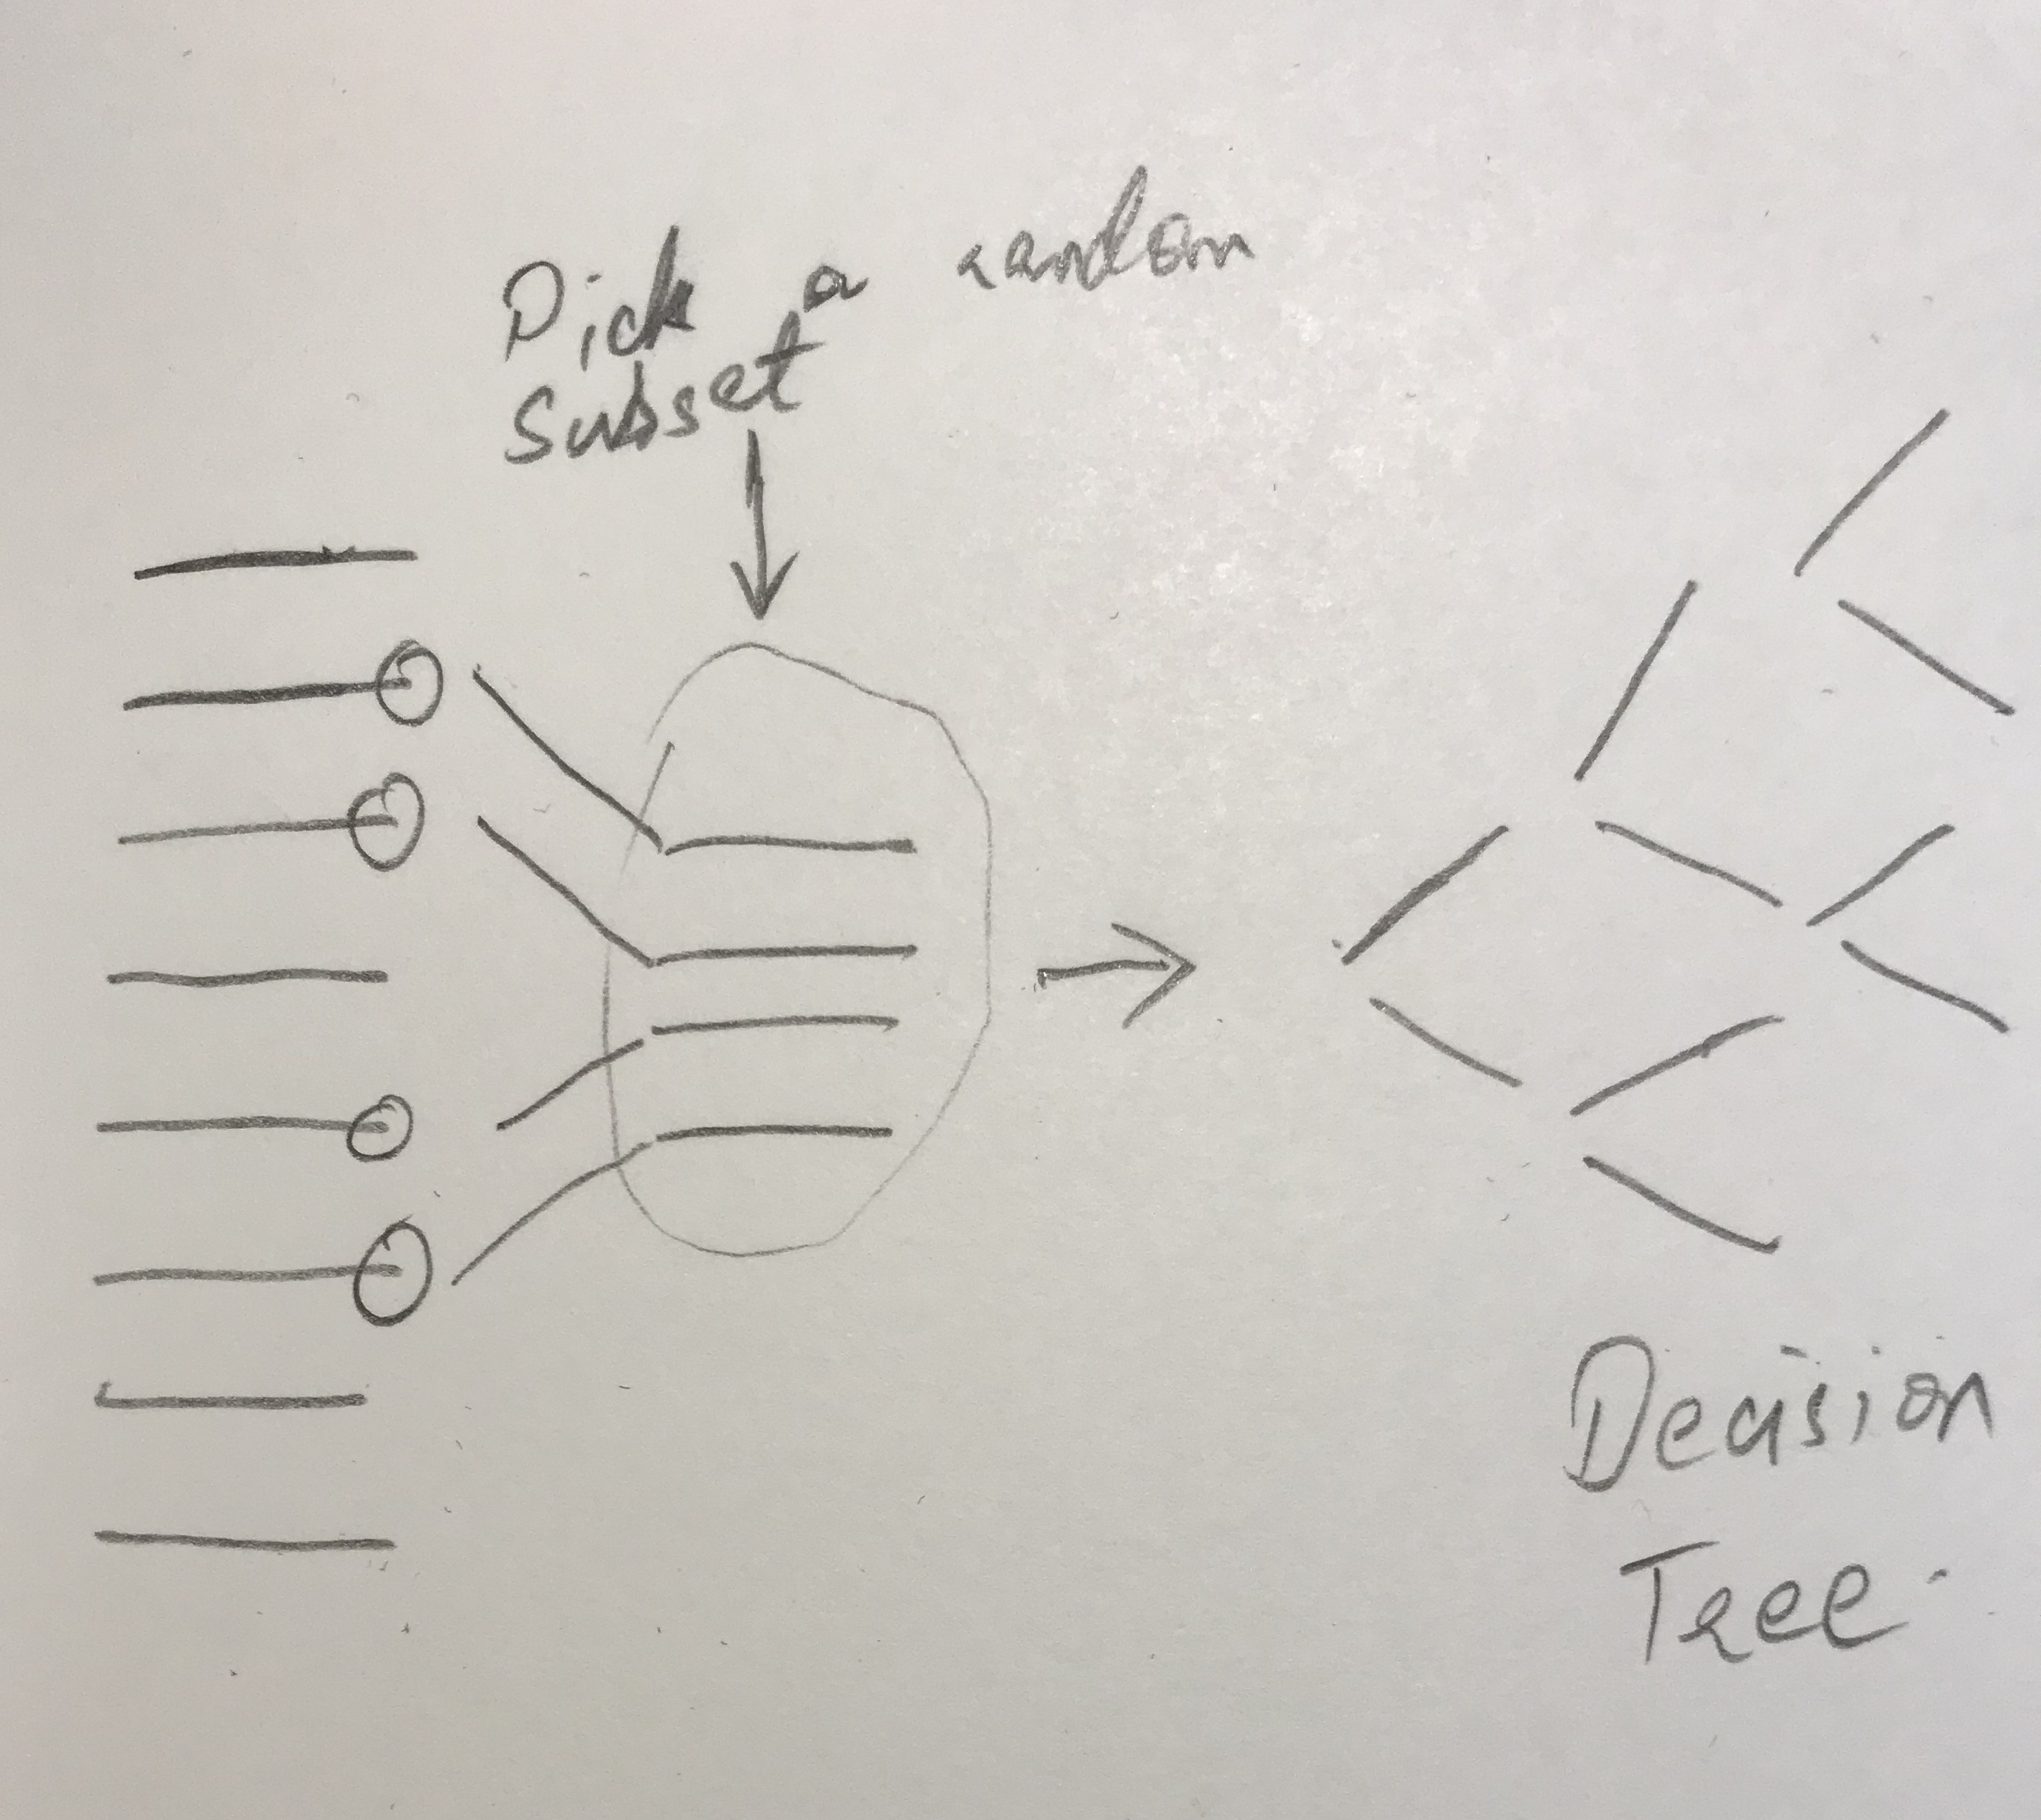

In [258]:
Image(filename = 'image2.png')

Lets train a Random Forest model now with the same two features that we used before. Note that `n_estimators` in scikit-learn are Decision Trees and we will use 40 of them.

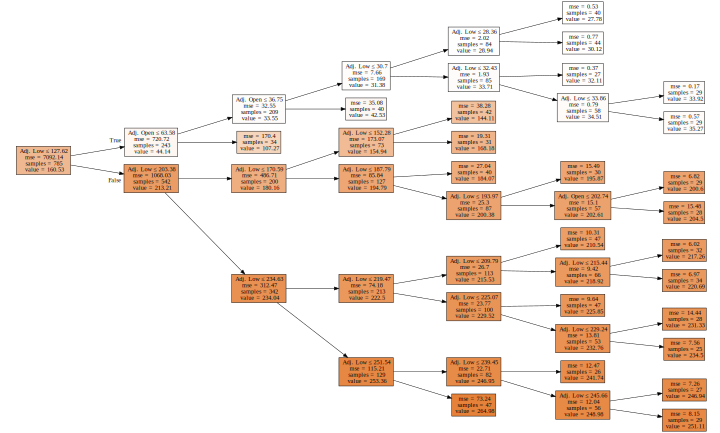

rmse train 4.397823614729115, rmse val 4.201441978163789, r^2 train 0.9973390381853801, r^2 val 0.9796000648754558


In [249]:
df_small = df
features = ['Adj. Open', 'Adj. Low']

X_df = df_small[features]
y_df = df_small['y']

X_train, X_val = X_df[:TRAIN], X_df[TRAIN:]
y_train, y_val = y_df[:TRAIN], y_df[TRAIN:]

model = RandomForestRegressor(n_estimators=40, bootstrap=True, min_samples_leaf=25)
model.fit(X_train, y_train)
draw_tree(model.estimators_[0], X_train, precision=2)

print_score(model)

We can see a slight improvement in RMSE and R-Squared for both datasets which is what we want. Our model seems to be working pretty well.

Remember that we mentioned that the average of all these trees indicates our prediction. This holds true as follows. 

For each of the Decision Trees, we get the predicted values. We then calculate the mean of predictions for a single datapoint. That mean value turns out to be very close to the y that we were trying to predict and is the same as what will be returned by the collective prediction of all the 40 Decision Trees.

In [253]:
preds = np.stack([t.predict(X_val) for t in model.estimators_])
print(f"Trees: {len(preds[:,0])},", f"Mean of 0th row for prediction from all trees: : {np.mean(preds[:,0])},", f"Actual y: {y_val[0]}")

Trees: 40, Mean of 0th row for prediction from all trees: : 188.32322750181893, Actual y: 185.02


Prediction from the Random Forest model is the same as the mean calculated above.

In [251]:
model.predict(X_val)[0]

188.32322750181896

There are different hyper parameters that we can experiment with to tune our model. We are not going to cover that in this blog post but just to give some taste, the following plot builds up an understanding for that.

In the following, we plot R-Squared against different number of Decision Trees used. As we increase the number of trees, we improve R-Squared (closer to 1 is better) and hence we are better able to tune our model.

However, somewhere around 15 trees, we stop seeing any further improvement in R-Squared statistic and the line tends to flatten out. This tells us that approximately 15 Decision Trees are as good as 40 in our example.

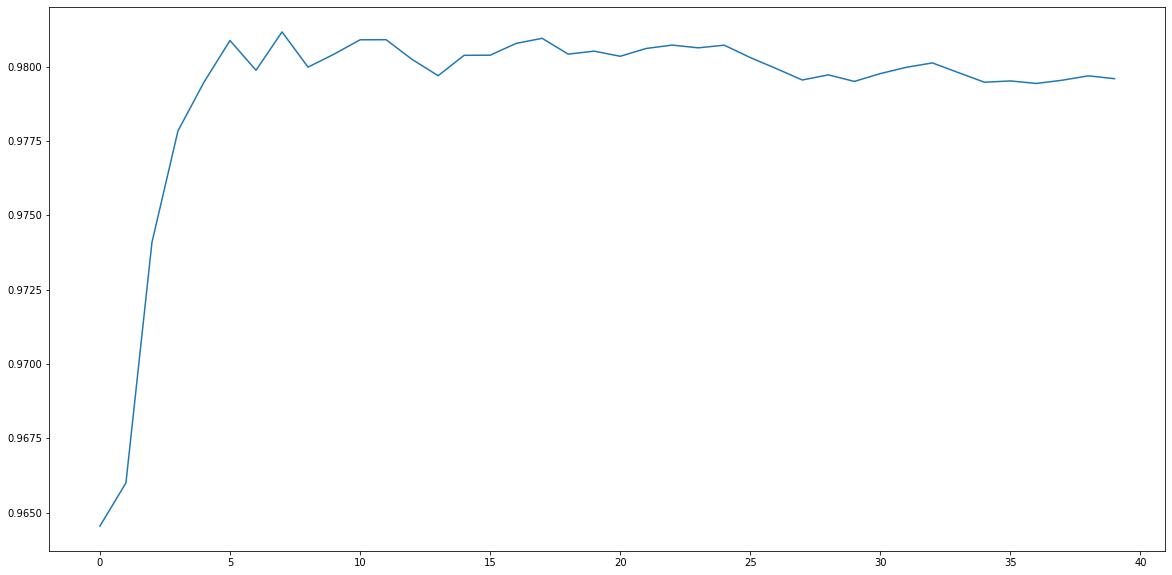

In [252]:
plt.plot([metrics.r2_score(y_val, np.mean(preds[:i+1], axis=0)) for i in range(40)]);

#### Conclusion

In this blog post, we started with the very basics of a Decision Tree and used that to build our understanding of the Random Forest.

We used a pre-cleaned dataset that was already feature-engineered so there wasn't any discussion around that. And although, we trained a pretty decent model using just two features, we can do even better by using more features and more hyper parameter tuning. This and more stuff will be covered in future blog posts soon.

Finally, this blog post wouldn't have been made possible without my learnings form Jeremy Howard's fastai courses (http://course18.fast.ai/ml.html).